In [1]:
import sys
sys.path.append(r'../')

import matplotlib.pyplot as plt
from models import SciNet
import numpy as np
import torch
import pandas as pd
import seaborn as sns

In [2]:
size = 25
size_ = 150
n = 3
scinet = SciNet(size,1,n,100)
scinet.load_state_dict(torch.load(f"../trained_models/scinet1--25-epoch200--latent-neuron-{n}.dat"))
t_max = 5
t = np.linspace(0, t_max, size)
min_fr, max_fr = 0, 5
fr = np.random.uniform(min_fr, max_fr, size_)
start_st, end_st = 0.01, 100
st = np.logspace(np.log10(start_st), np.log10(end_st), size_, endpoint = True)
act = {}
for i in range(n):
    act[f'act{i}'] = []
def f(t, st, fr):
    return st**2 * fr * (1 - t/st - np.exp(-t/st))
for st_ in st:
    for fr_ in fr:
        example = list(f(t, st_, fr_))
        t_pred = np.random.uniform(0, t_max)
        example.append(t_pred)

        example_tensor = torch.Tensor([example]).reshape(1, -1)
        results = scinet.forward(example_tensor)

        latent_layer = scinet.mu.detach().numpy()[0]
        for i in range(n):
            act[f"act{i}"].append((st_,fr_, latent_layer[i]))

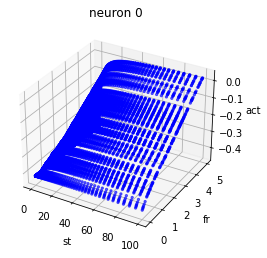

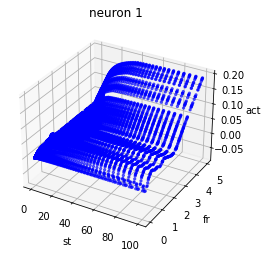

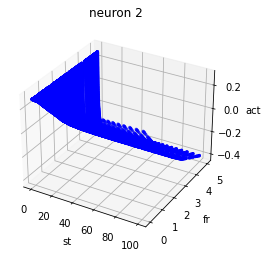

In [3]:
for i in range(n):
    x = [point[0] for point in act[f"act{i}"]]
    y = [point[1] for point in act[f"act{i}"]]
    z = [point[2] for point in act[f"act{i}"]]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='b', marker='.', alpha=0.6, linewidth = 1)

    # Customize labels and title
    ax.set_xlabel('st')
    ax.set_ylabel('fr')
    ax.set_zlabel('act')
    ax.set_title(f'neuron {i}')
    plt.savefig(f'../plot/1-latent-neuron/neuron-{i}.pdf')
    # Show the plot
    plt.show()


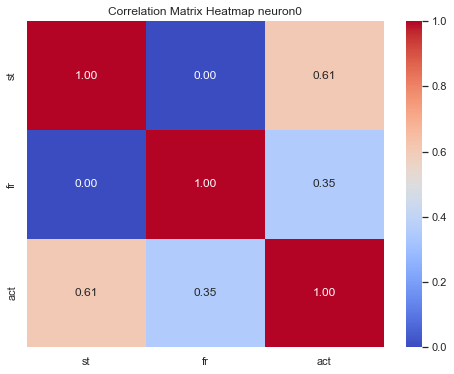

<Figure size 432x288 with 0 Axes>

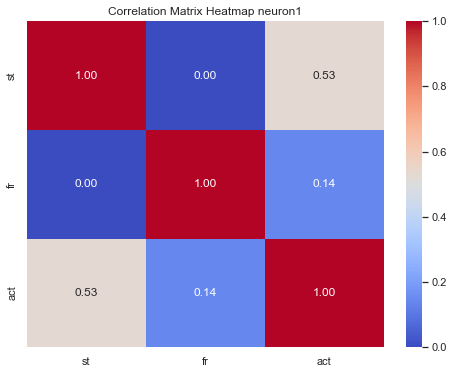

<Figure size 432x288 with 0 Axes>

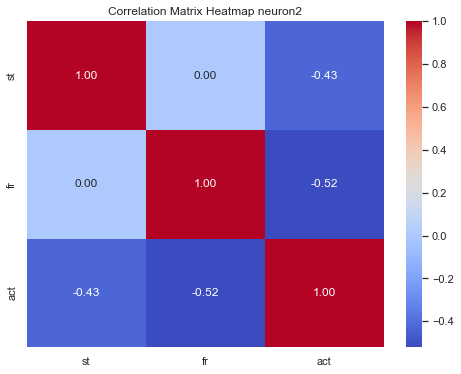

<Figure size 432x288 with 0 Axes>

In [4]:
for i in range(n):
     st__ = [point[0] for point in act[f"act{i}"]]
     fr__ = [point[1] for point in act[f"act{i}"]]
     act_ = [point[2] for point in act[f"act{i}"]]
     data_matrix = np.column_stack((st__, fr__, act_))
     correlation_matrix = np.corrcoef(data_matrix, rowvar=False)
     sns.set(style='white')
     plt.figure(figsize=(8, 6))
     sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
               xticklabels=['st', 'fr', 'act'], yticklabels=['st', 'fr', 'act'])
     plt.title(f'Correlation Matrix Heatmap neuron{i}')
     plt.show()
     plt.savefig(f'../plot/{n}-latent-neuron/heatmap neuron {i}.pdf')


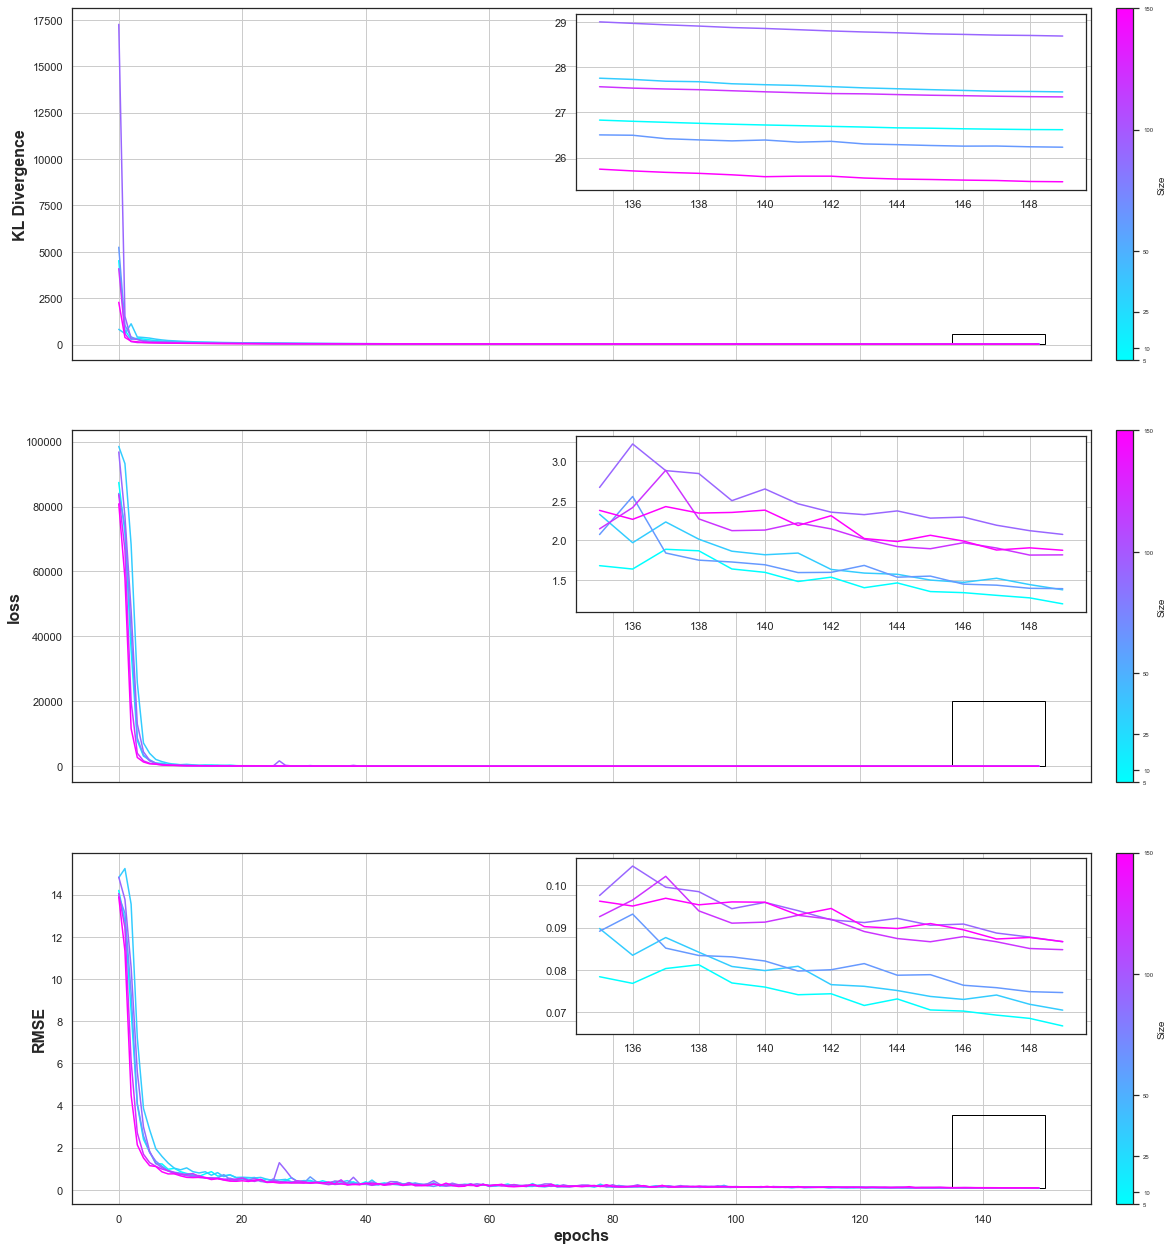

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import json
import matplotlib.pylab as pl
from matplotlib.cm import ScalarMappable
import numpy as np

with open("../log.json", "r") as f:
    file = json.load(f)
file = {"runs": file["runs"][:-2]}
# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(22, 22), sharex=True)

# Define the starting epoch for zooming in
start_epoch = int(file["runs"][0]['epochs'] * 0.9)  # Change this to your desired starting epoch
start = 0
end_epoch = file["runs"][0]['epochs']  # Change this to your desired ending epoch
epochs = list(range(end_epoch))

# Extract the 'size' values from the JSON data
size_values = [run['size'] for run in file["runs"]]

# Create a colormap based on 'size' values
colors = pl.cm.cool(np.linspace(0, 1, len(size_values)))
metrics = ["kl", "loss", "RMSE"]
for j in range(len(metrics)):
    # Plot the first subplot
    for i in range(len(file["runs"])):
        axs[j].plot(epochs[start:], file["runs"][i][metrics[j]][start:], color=colors[i], label=f'Size {size_values[i]}')
    if metrics[j] == "kl":
        axs[j].set_ylabel("KL Divergence", fontsize=16, fontweight='bold')
        axs[j].grid(True)
    else:
        axs[j].set_ylabel(metrics[j], fontsize=16, fontweight='bold')
        axs[j].grid(True)

    # Create an inset_axes for zooming in on the first subplot
    axins1 = inset_axes(axs[j], width="50%", height="50%", loc='upper right')
    for i in range(len(file["runs"])):
        axins1.plot(epochs[start_epoch:end_epoch], file["runs"][i][metrics[j]][start_epoch:end_epoch], color=colors[i])
    axins1.grid(True)

    # Create a ScalarMappable to map colors to values for the colorbar
    sm = ScalarMappable(cmap=pl.cm.cool, norm=plt.Normalize(vmin=min(size_values), vmax=max(size_values)))
    sm.set_array([])  # Set an empty array for now; you can set the values later

    # Add a colorbar with a smaller label
    cbar = plt.colorbar(sm, ax=axs[j], pad=0.02)
    cbar.ax.set_title("", fontsize=10)  # Remove the colorbar title
    cbar.set_label("Size", fontsize=10)  # Set a smaller colorbar label

    # Set the colorbar ticks and tick labels to correspond to 'size' values
    cbar.set_ticks(size_values)
    cbar.set_ticklabels([f'{size}' for size in size_values], fontsize=6)
    # Add a thinner, black rectangle with smaller height to the initial plot indicating the zoomed-in area
    rect1 = Rectangle((start_epoch, min(file["runs"][i][metrics[j]][start:])), end_epoch - start_epoch,
                      (max(file["runs"][i][metrics[j]][start:]) - min(file["runs"][i][metrics[j]][start:])) / 4,
                      fill=False, edgecolor='black', linewidth=1)
    axs[j].add_patch(rect1)
axs[j].set_xlabel("epochs", fontsize=16, fontweight='bold')
plt.savefig(f'../plot/{n}-latent-neuron/analysis.pdf')

plt.show()
